In [1]:
import csv
import urllib


exclude = []
exclude.append('http://www.bigdata.com/')
exclude.append('http://www.bigdata.com/')

#total number of queries
sample = []
count = 0
with open("I7_status2xx_Joined.tsv") as file:
    tsv_file = csv.reader(file, delimiter="\t")
    for line in tsv_file:
        count = count + 1
        if count > 1:
            query = urllib.parse.unquote_plus(line[0]).replace('> *', '>*').replace('> / <', '>/<')
            sample.append(query)
            #if 'http://www.bigdata.com/' not in query and 'wikibase:label' not in query:
            if count == 100001:
                break
print(len(sample))

100000


In [2]:
import csv
import urllib
from rdflib.plugins.sparql.parser import parseQuery


exclude = []
exclude.append('http://www.bigdata.com/')

#queries that obey normal SPARQL syntax
sample_SPARQL = []
count_restricted = 0
for line in sample:
    #print(query)
    #parseQuery(query)
    #if 'http://www.bigdata.com/' not in query and 'wikibase:label' not in query:
    b = True
    for e in exclude:
        if e in line:
            b = False
    if b:
        sample_SPARQL.append(line)
        count_restricted = count_restricted+1
print(len(sample_SPARQL))
print(100000-len(sample_SPARQL))

88622
11378


In [3]:
import csv
import urllib
from rdflib.plugins.sparql.parser import parseQuery


exclude = []
exclude.append('http://www.wikidata.org/prop/statement/')
#exclude.append('http://www.wikidata.org/prop/')

#total number of queries
sample_SPARQL_truthy = []
count_restricted = 0
for line in sample_SPARQL:
    #parseQuery(query)
    #if 'http://www.bigdata.com/' not in query and 'wikibase:label' not in query:
    b = True
    for e in exclude:
        if e in line:
            b = False
    if b:
        #print(line)
        sample_SPARQL_truthy.append(line)
        count_restricted = count_restricted+1
print(len(sample_SPARQL_truthy))

84250


In [26]:
# def get_delay(date):
#     try:
#         date = datetime.datetime.strptime(date, '%a, %d %b %Y %H:%M:%S GMT')
#         timeout = int((date - datetime.datetime.now()).total_seconds())
#     except ValueError:
#         timeout = int(date)
#     return timeout


# def make_request(params):
#     r = requests.get(wikidata_url, params)
#     print(r.status_code)
#     if r.status_code == 200:
#         if r.json()['results']['bindings']:
#             return r.json()
#         else:
#             return None
#     if r.status_code == 500:
#         return None
#     if r.status_code == 403:
#         return None
#     if r.status_code == 429:
#         timeout = get_delay(r.headers['retry-after'])
#         print('Timeout {} m {} s'.format(timeout // 60, timeout % 60))
#         time.sleep(timeout)
#         make_request(params)


# wikidata_url = 'https://query.wikidata.org/sparql'
# headers = {'User-Agent': 'Chrome/77.0.3865.90'}

from SPARQLWrapper import SPARQLWrapper, JSON
import datetime
#host = "http://localhost:4567/api/sparql"

host1 = "http://query.wikidata.org/sparql"
sparql1 = SPARQLWrapper(host1, agent='D063520 (https://the-qa-company.com/; dennis.diefenbach@the-qa-company.com)')
sparql1.setReturnFormat(JSON)
host2 = "https://qanswer-core1.univ-st-etienne.fr/api/endpoint/open/wikidata/sparql"
#host2 = "http://localhost:1234/api/endpoint/sparql"
sparql2 = SPARQLWrapper(host2, agent='D063520 (https://the-qa-company.com/; dennis.diefenbach@the-qa-company.com)')
sparql2.setReturnFormat(JSON)
sparql2.addCustomHttpHeader("timeout", "61")
sparql2.setTimeout(60)

time1 = []
time2 = []
number_result1 = []
number_result2 = []
error1 = []
error2 = []
count = 0
for query in sample_SPARQL_truthy:
    #print(query.replace('\n', ' '))
    count = count + 1
    if count > 0 and count <= 3601:
        print(count)
        try:
            print("Wikidata start")
            before = datetime.datetime.now()
            sparql1.setQuery(query+"")
            ret = sparql1.queryAndConvert()
            delta = datetime.datetime.now() - before
            microseconds = delta.total_seconds() * 1000
            time1.append(microseconds)

            number_results = 0
            if 'boolean' in ret:
                if ret['boolean'] == 'True':
                    number_result1.append(1)
                else:
                    number_result1.append(0)
            else:
                for r in ret["results"]["bindings"]:
                    number_results = number_results+1
            number_result1.append(number_results)
            error1.append(False)
            print("Wikidata end")
        except Exception as inst:
            print(inst)
            print('Wikidata ',query)
            time1.append(microseconds)
            number_result1.append(0)
            error1.append(True)
        
        
        try:
            print("QAnswer start")
            before = datetime.datetime.now()
            sparql2.setQuery(query+"")
        
            ret = sparql2.queryAndConvert()
            delta = datetime.datetime.now() - before
            microseconds = delta.total_seconds() * 1000
            time2.append(microseconds)

            number_results = 0
            if 'boolean' in ret:
                if ret['boolean'] == 'True':
                    number_result2.append(1)
                else:
                    number_result2.append(0)
                #print(ret)
            else:
                for r in ret["results"]["bindings"]:
                    number_results = number_results+1
            number_result2.append(number_results)
            error2.append(False)
            print("QAnswer end")
        except Exception as inst:
            print(inst)
            print('qEndpoint ',query)
            time2.append(microseconds)
            number_result2.append(0)
            error2.append(True)
print(time1)
print(time2)
diff_time = []
for i in range(0,len(time1)):
    diff_time.append(time1[i]-time2[i])
print(diff_time)

sum_total_time1 = 0
for i in range(0,len(time1)):
    sum_total_time1 += time1[i]
sum_total_time1 = sum_total_time1 /1000
print('sum_total_time1 ', sum_total_time1)

sum_total_time2 = 0
for i in range(0,len(time2)):
    sum_total_time2 += time2[i]
sum_total_time2 = sum_total_time2 /1000
print('sum_total_time2 ', sum_total_time2)


print(number_result1)
print(number_result2)
diff_number = []
for i in range(0,len(number_result1)):
    diff_number.append(number_result1[i]-number_result2[i])
print(diff_number)





    

1
Wikidata start
Wikidata end
QAnswer start
QAnswer end
2
Wikidata start
Wikidata end
QAnswer start
QAnswer end
3
Wikidata start
Wikidata end
QAnswer start
QAnswer end
4
Wikidata start
Wikidata end
QAnswer start
QAnswer end
5
Wikidata start
Wikidata end
QAnswer start
QAnswer end
6
Wikidata start
Wikidata end
QAnswer start
QAnswer end
7
Wikidata start
Wikidata end
QAnswer start
QAnswer end
8
Wikidata start
Wikidata end
QAnswer start
QAnswer end
9
Wikidata start
Wikidata end
QAnswer start
QAnswer end
10
Wikidata start
Wikidata end
QAnswer start
QAnswer end
11
Wikidata start
Wikidata end
QAnswer start
QAnswer end
12
Wikidata start
Wikidata end
QAnswer start
QAnswer end
13
Wikidata start
Wikidata end
QAnswer start
QAnswer end
14
Wikidata start
Wikidata end
QAnswer start
QAnswer end
15
Wikidata start
Wikidata end
QAnswer start
QAnswer end
16
Wikidata start
Wikidata end
QAnswer start
QAnswer end
17
Wikidata start
Wikidata end
QAnswer start
QAnswer end
18
Wikidata start
Wikidata end
QAnswer s

In [92]:
import numpy
arr = numpy.array(diff_time)
import matplotlib.pyplot as plt

In [100]:
numpy.max(arr), numpy.min(arr), numpy.mean(arr), numpy.median(arr)

(77878.52, -18349.277000000002, 122.19142694444444, 149.2115)

In [97]:
numpy.reshape(arr[:3600], (60,60), order='C')

array([[103.764, 331.589, 130.972, ..., 202.966, 157.013,  33.342],
       [271.625,  98.626, 148.132, ..., 121.542, 406.034, 124.583],
       [125.784, 200.058, 123.738, ..., 163.887, 224.238, 168.499],
       ...,
       [393.865, 327.124, 156.41 , ..., 164.942, 196.22 , 314.353],
       [155.495, 131.926, 136.634, ..., 124.501, 134.063, 440.637],
       [157.423,  31.772, 123.459, ..., 127.588, 149.255, 216.353]])

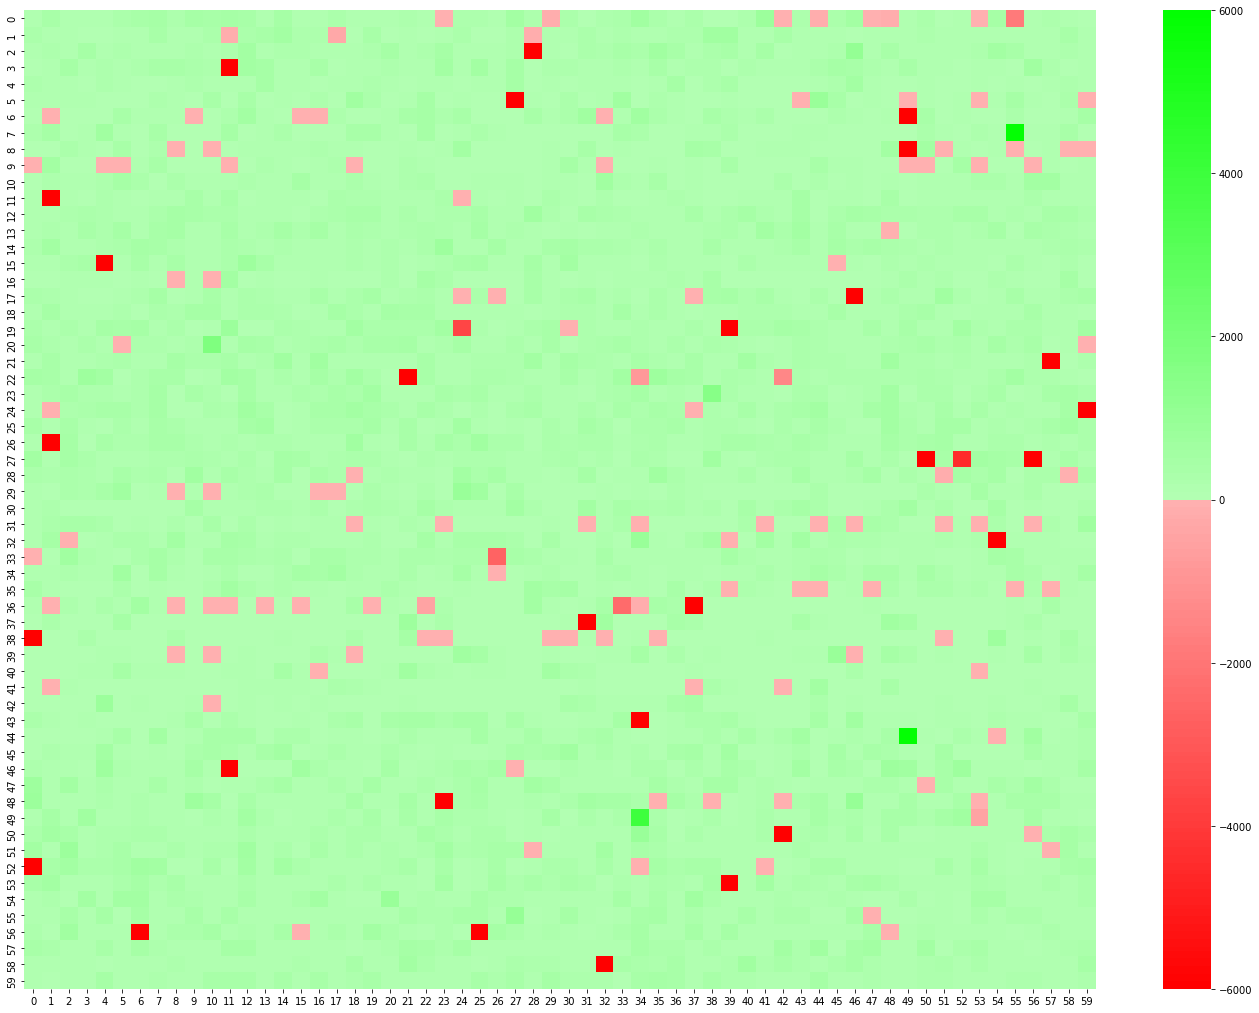

In [123]:
fig = plt.figure(figsize=(24, 18))
import seaborn as sns
from matplotlib import colors
def get_custom_color_palette():
    return ListedColormap([*[(1, 0, 0, alpha) for alpha in numpy.arange(1, 0.3, -0.01)],
                           *[(0, 1, 0, alpha) for alpha in numpy.arange(0.3, 1, 0.01)]])
arr = numpy.reshape(arr[:3600], (60,60), order='C')
# print(arr)
ax = sns.heatmap(arr, cmap=get_custom_color_palette(), center=0, vmax=6000, vmin=-6000)

In [9]:
# def get_delay(date):
#     try:
#         date = datetime.datetime.strptime(date, '%a, %d %b %Y %H:%M:%S GMT')
#         timeout = int((date - datetime.datetime.now()).total_seconds())
#     except ValueError:
#         timeout = int(date)
#     return timeout


# def make_request(params):
#     r = requests.get(wikidata_url, params)
#     print(r.status_code)
#     if r.status_code == 200:
#         if r.json()['results']['bindings']:
#             return r.json()
#         else:
#             return None
#     if r.status_code == 500:
#         return None
#     if r.status_code == 403:
#         return None
#     if r.status_code == 429:
#         timeout = get_delay(r.headers['retry-after'])
#         print('Timeout {} m {} s'.format(timeout // 60, timeout % 60))
#         time.sleep(timeout)
#         make_request(params)


# wikidata_url = 'https://query.wikidata.org/sparql'
# headers = {'User-Agent': 'Chrome/77.0.3865.90'}

from SPARQLWrapper import SPARQLWrapper, JSON
import datetime
#host = "http://localhost:4567/api/sparql"

host1 = "http://query.wikidata.org/sparql"
sparql1 = SPARQLWrapper(host1, agent='D063520 (https://the-qa-company.com/; dennis.diefenbach@the-qa-company.com)')
sparql1.setReturnFormat(JSON)
#host2 = "https://qanswer-core1.univ-st-etienne.fr/api/endpoint/open/wikidata/sparql"
host2 = "http://localhost:1234/api/endpoint/sparql"
sparql2 = SPARQLWrapper(host2, agent='D063520 (https://the-qa-company.com/; dennis.diefenbach@the-qa-company.com)')
sparql2.setReturnFormat(JSON)
sparql2.addCustomHttpHeader("timeout", "60")
#sparql2.setTimeout(60)

time1 = []
time2 = []
number_result1 = []
number_result2 = []
error1 = []
error2 = []
count = 0
for query in sample_SPARQL_truthy:
    #print(query.replace('\n', ' '))
    count = count + 1
    if count > 0 and count <= 3603 and count != 1534 and count != 1846 and count != 2707:
    #if count == 1534:
        print(count)
        try:
            print("Wikidata start")
            before = datetime.datetime.now()
            sparql1.setQuery(query+"        ")
            ret = sparql1.queryAndConvert()
            delta = datetime.datetime.now() - before
            microseconds = delta.total_seconds() * 1000
            time1.append(microseconds)

            number_results = 0
            if 'boolean' in ret:
                if ret['boolean'] == 'True':
                    number_result1.append(1)
                else:
                    number_result1.append(0)
            else:
                for r in ret["results"]["bindings"]:
                    number_results = number_results+1
            number_result1.append(number_results)
            error1.append(False)
            print("Wikidata end")
        except Exception as inst:
            print(inst)
            print('Wikidata ',query)
            time1.append(microseconds)
            number_result1.append(0)
            error1.append(True)
        
        
        try:
            print("QAnswer start")
            before = datetime.datetime.now()
            sparql2.setQuery(query+"         ")
        
            ret = sparql2.queryAndConvert()
            delta = datetime.datetime.now() - before
            microseconds = delta.total_seconds() * 1000
            time2.append(microseconds)

            number_results = 0
            if 'boolean' in ret:
                if ret['boolean'] == 'True':
                    number_result2.append(1)
                else:
                    number_result2.append(0)
                #print(ret)
            else:
                for r in ret["results"]["bindings"]:
                    number_results = number_results+1
            number_result2.append(number_results)
            error2.append(False)
            print("QAnswer end")
        except Exception as inst:
            print(inst)
            print('qEndpoint ',query)
            time2.append(microseconds)
            number_result2.append(0)
            error2.append(True)
print(time1)
print(time2)
diff_time = []
for i in range(0,len(time1)):
    diff_time.append(time1[i]-time2[i])
print(diff_time)

sum_total_time1 = 0
for i in range(0,len(time1)):
    sum_total_time1 += time1[i]
sum_total_time1 = sum_total_time1 /1000
print('sum_total_time1 ', sum_total_time1)

sum_total_time2 = 0
for i in range(0,len(time2)):
    sum_total_time2 += time2[i]
sum_total_time2 = sum_total_time2 /1000
print('sum_total_time2 ', sum_total_time2)


print(number_result1)
print(number_result2)
diff_number = []
for i in range(0,len(number_result1)):
    diff_number.append(number_result1[i]-number_result2[i])
print(diff_number)

1
Wikidata start
Wikidata end
QAnswer start
QAnswer end
2
Wikidata start
Wikidata end
QAnswer start
QAnswer end
3
Wikidata start
Wikidata end
QAnswer start
QAnswer end
4
Wikidata start
Wikidata end
QAnswer start
QAnswer end
5
Wikidata start
Wikidata end
QAnswer start
QAnswer end
6
Wikidata start
Wikidata end
QAnswer start
QAnswer end
7
Wikidata start
Wikidata end
QAnswer start
QAnswer end
8
Wikidata start
Wikidata end
QAnswer start
QAnswer end
9
Wikidata start
Wikidata end
QAnswer start
QAnswer end
10
Wikidata start
Wikidata end
QAnswer start
QAnswer end
11
Wikidata start
Wikidata end
QAnswer start
QAnswer end
12
Wikidata start
Wikidata end
QAnswer start
QAnswer end
13
Wikidata start
Wikidata end
QAnswer start
QAnswer end
14
Wikidata start
Wikidata end
QAnswer start
QAnswer end
15
Wikidata start
Wikidata end
QAnswer start
QAnswer end
16
Wikidata start
Wikidata end
QAnswer start
QAnswer end
17
Wikidata start
Wikidata end
QAnswer start
QAnswer end
18
Wikidata start
Wikidata end
QAnswer s

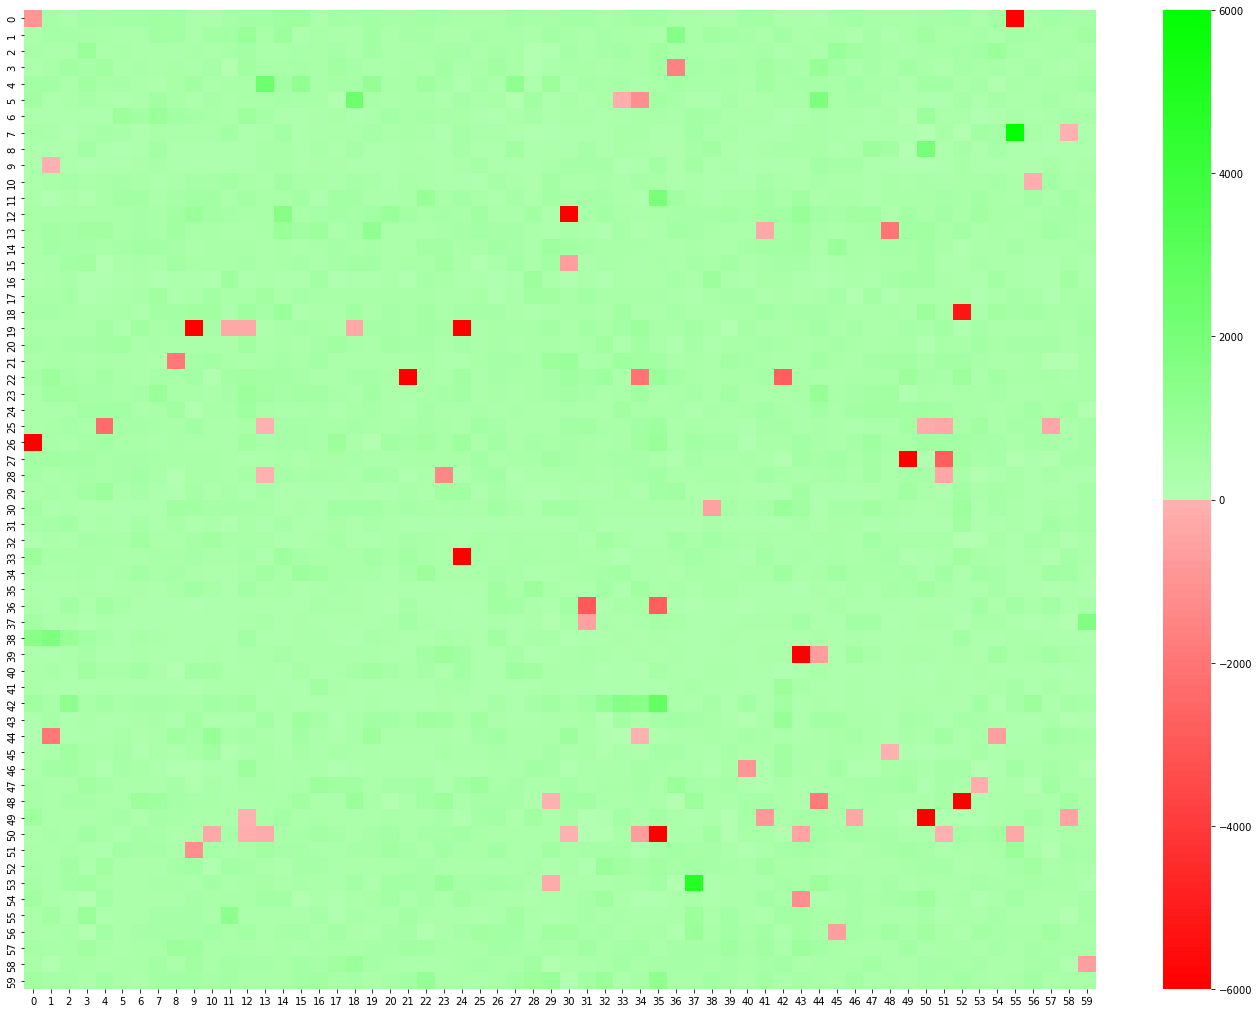

In [12]:
from matplotlib.colors import ListedColormap
import numpy
arr = numpy.array(diff_time)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(24, 18))
import seaborn as sns
from matplotlib import colors
def get_custom_color_palette():
    return ListedColormap([*[(1, 0, 0, alpha) for alpha in numpy.arange(1, 0.3, -0.01)],
                           *[(0, 1, 0, alpha) for alpha in numpy.arange(0.3, 1, 0.01)]])
arr = numpy.reshape(arr[:3600], (60,60), order='C')
# print(arr)
ax = sns.heatmap(arr, cmap=get_custom_color_palette(), center=0, vmax=6000, vmin=-6000)

In [16]:
sum_total_time1 = 0
for i in range(0,len(time1)):
    if time2[i] < time1[i]:
        sum_total_time1 += 1
sum_total_time1 = sum_total_time1
print('sum_total_time1 ', sum_total_time1)



sum_total_time1  68
